In [5]:
#!/usr/bin/env python3
"""
单独测试Omni检测器的单轮检测
将检测到的对象加入向量数据库
"""

import sys
import os
import io
import base64
import yaml
import cv2
from PIL import Image
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 添加项目路径
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from BottomUpAgent.Detector import Detector
from BottomUpAgent.LongMemory import LongMemory
from BottomUpAgent.VectorMemory import VectorMemory
from BottomUpAgent.Eye import Eye


/home/jch/anaconda3/envs/bottomup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jch/anaconda3/envs/bottomup/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /home/jch/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /home/jch/.paddlex/official_mode

In [6]:


def load_config():
    """加载配置文件"""
    config_paths = [
        "config/slay_the_spire_vector_config.yaml",
        "configs/sts_omni_claude.yaml"
    ]
    
    for config_path in config_paths:
        if os.path.exists(config_path):
            with open(config_path, 'r', encoding='utf-8') as f:
                config = yaml.safe_load(f)
            
            # 确保使用omni检测器
            if 'detector' not in config:
                config['detector'] = {}
            config['detector']['type'] = 'omni'
            
            print(f"✓ 使用配置文件: {config_path}")
            return config
    
    print("✗ 未找到可用的配置文件")
    return None


In [7]:

"""测试Omni检测器单轮检测"""
print("=== Omni检测器单轮测试 ===\n")

# 1. 加载配置
config = load_config()


=== Omni检测器单轮测试 ===

✓ 使用配置文件: config/slay_the_spire_vector_config.yaml


In [8]:

# 2. 初始化组件
try:
    print("初始化Detector...")
    detector = Detector(config)
    
    print("初始化LongMemory...")
    long_memory = LongMemory(config)
    vector_memory = long_memory.vector_memory
    
    print("✓ 组件初始化成功")
    print(f"检测器类型: {detector.detector_type}")
    
except Exception as e:
    print(f"✗ 组件初始化失败: {e}")
    import traceback
    traceback.print_exc()


初始化Detector...
load som model from  ./weights/icon_detect/model.pt
Omniparser initialized!!!
cuda:0 <class 'ultralytics.models.yolo.model.YOLO'>
初始化LongMemory...
Use default embedding in the vector database.
✓ 组件初始化成功
检测器类型: omni


In [10]:

eye = Eye(config)
test_image_or_path = eye.get_screenshot_cv()
try:
    if test_image_or_path is not None:
        pass
except Exception as e:
    print("✗ 未找到可用的测试图像")

print(f"✓ 窗口截图加载成功")
image = test_image_or_path
print(f"图像尺寸: {image.shape}")


screenshot mode: RGB
✓ 窗口截图加载成功
图像尺寸: (1080, 1920, 3)


In [11]:

# 4. 清空向量数据库（确保干净的测试环境）
print("\n--- 清空向量数据库 ---")
try:
    vector_memory.clear_database()
    print("✓ 向量数据库已清空")
except Exception as e:
    print(f"清空数据库时出现警告: {e}")

# 显示清空后的统计信息
try:
    initial_stats = vector_memory.get_collection_stats()
    print(f"清空后统计: {initial_stats}")
except Exception as e:
    print(f"获取初始统计失败: {e}")


[2025-08-09 20:01:42,096] [   ERROR] VectorMemory.py:479 - 获取统计信息失败: Collection [c31589ba-744d-402e-b371-60b86ef8fe06] does not exists.



--- 清空向量数据库 ---
✓ 向量数据库已清空
清空后统计: {}


In [12]:

# 5. 使用Omni检测对象
print("\n--- Omni对象检测 ---")
try:
    detected_objects, labled_img = detector.extract_objects_omni(image)
    print(f"✓ 检测完成，共检测到 {len(detected_objects)} 个对象")
    
    # 显示前几个检测结果的详细信息
    print("\n检测结果详情:")
    for i, obj in enumerate(detected_objects):
        content = obj.get('content', 'N/A')
        bbox = obj['bbox']
        area = obj['area']
        type = obj['type']
        center = obj['center']
        
        print(f"OBJECT {i+1}:")
        print(f"  type: '{type}'")
        print(f"  content: '{content}'")
        print(f"  bbox: {bbox}")
        print(f"  area: {area}")
        print(f"  center_pos: {center}")
        print(f"  size_pixel: {obj['image'].shape}")
        print()
    
except Exception as e:
    print(f"✗ 检测失败: {e}")
    import traceback
    traceback.print_exc()



--- Omni对象检测 ---

0: 736x1280 8 icons, 45.1ms
Speed: 3.9ms preprocess, 45.1ms inference, 18.7ms postprocess per image at shape (1, 3, 736, 1280)
time to get parsed content: 0.11304068565368652
NUM of boxes: 34 OCR: 28 icons: 6


/home/jch/anaconda3/envs/bottomup/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


✓ 检测完成，共检测到 33 个对象

检测结果详情:
OBJECT 1:
  type: 'text'
  content: 'Junchu'
  bbox: [23, 17, 102, 29]
  area: 2958
  center_pos: (74, 31)
  size_pixel: (29, 102, 3)

OBJECT 2:
  type: 'text'
  content: 'the Ironclad'
  bbox: [136, 21, 118, 24]
  area: 2832
  center_pos: (195, 33)
  size_pixel: (24, 118, 3)

OBJECT 3:
  type: 'text'
  content: '99'
  bbox: [495, 20, 34, 25]
  area: 850
  center_pos: (512, 32)
  size_pixel: (25, 34, 3)

OBJECT 4:
  type: 'text'
  content: 'l'
  bbox: [958, 25, 8, 17]
  area: 136
  center_pos: (962, 33)
  size_pixel: (17, 8, 3)

OBJECT 5:
  type: 'text'
  content: '[V2.3.4] (12-18-2022)'
  bbox: [1700, 75, 204, 27]
  area: 5508
  center_pos: (1802, 88)
  size_pixel: (27, 204, 3)

OBJECT 6:
  type: 'text'
  content: '2343PEDP881JM'
  bbox: [1734, 102, 171, 20]
  area: 3420
  center_pos: (1819, 112)
  size_pixel: (20, 171, 3)

OBJECT 7:
  type: 'text'
  content: '13/13'
  bbox: [1486, 719, 64, 24]
  area: 1536
  center_pos: (1518, 731)
  size_pixel: (24, 64, 3

--- 生成检测结果可视化 ---


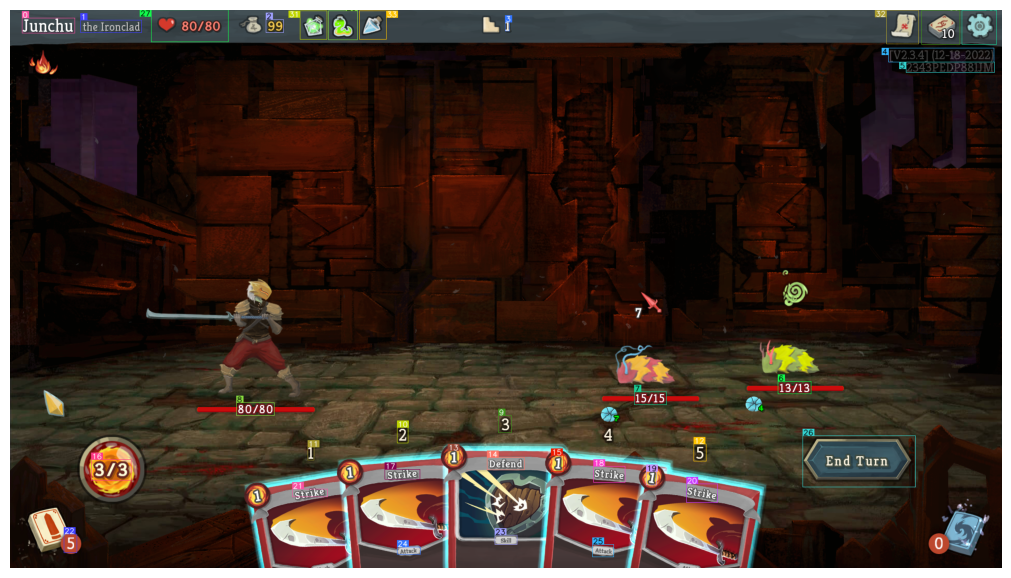

In [15]:

# 6. 可视化检测结果
print("--- 生成检测结果可视化 ---")
try:
    # save labled_img to scripts/omni_detection_result.png
    # Image.open(io.BytesIO(base64.b64decode(labled_img))).save(f'scripts/omni_detection_result.png')

    # in Notebook, plot directly to the following output
    img = Image.open(io.BytesIO(base64.b64decode(labled_img)))
    plt.figure(figsize=(12.8, 10.8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"可视化生成失败: {e}")


In [16]:

# 7. 连接到向量数据库
print("--- 存储到向量数据库 ---")
# state = create_vector_state(detected_objects)

try:
    vector_memory._init_chroma_db(embedding_type=config['vector_memory'].get('embedding_type',''))
    # 显示向量数据库统计
    stats = vector_memory.get_collection_stats()
    print(f"向量数据库统计: {stats}")
    
except Exception as e:
    print(f"✗ 存储失败: {e}")
    import traceback
    traceback.print_exc()


--- 存储到向量数据库 ---
Use default embedding in the vector database.
向量数据库统计: {'total_objects': 0, 'game_name': 'Slay the Spire', 'vector_dim': 512, 'db_path': './data/vector/slay_the_spire'}


In [ ]:

# 8. 测试逐个向量数据库存储操作
print("\n--- 逐个向量数据库存储操作测试 ---")

# 测试单个对象存储
# for i, obj in enumerate(detected_objects):
#     try:
#         stored_id = vector_memory.store_object(obj)
#         print(f"✓ 单个对象存储成功: {stored_id}")
        
#         # # 测试相似对象查找
#         similar_objects = vector_memory.find_similar_objects(obj, top_k=3)
#         print(f"找到 {len(similar_objects)} 个相似对象:")
        
#         # for j, similar in enumerate(similar_objects):
#         #     similarity = similar.get('similarity', 0)
#         #     content = similar.get('content', 'N/A')
#         #     print(f"  相似对象 {j+1}: '{content}' (相似度: {similarity:.3f})")
            
#     except Exception as e:
#         print(f"向量存储操作失败: {e}")


In [18]:


# 9. 测试批量向量数据库存储功能
print("\n--- 批量向量数据库存储测试 ---")

# 选择部分对象进行批量存储测试
# batch_objects = detected_objects[0:15]  # 选择第x~y个对象, detected_objects[x-1:y]
batch_objects = detected_objects
try:
    batch_ids = vector_memory.batch_store_objects(batch_objects)
    print(f"✓ 批量存储成功: {len(batch_ids)} 个对象")
    
    for i, batch_id in enumerate(batch_ids):
        content = batch_objects[i].get('content', 'N/A')
        print(f"  批量对象 {i+1}: '{content}' -> {batch_id}")
        
except Exception as e:
    print(f"批量存储失败: {e}")



--- 批量向量数据库存储测试 ---
✓ 批量存储成功: 33 个对象
  批量对象 1: 'Junchu' -> obj_text_e41db2ff
  批量对象 2: 'the Ironclad' -> obj_text_edd71dda
  批量对象 3: '99' -> obj_text_868da501
  批量对象 4: 'l' -> obj_text_863c25a7
  批量对象 5: '[V2.3.4] (12-18-2022)' -> obj_text_225ab1f2
  批量对象 6: '2343PEDP881JM' -> obj_text_c6a75941
  批量对象 7: '13/13' -> obj_text_e60f9842
  批量对象 8: '15/15' -> obj_text_186a3fa2
  批量对象 9: '80/80' -> obj_text_8d426229
  批量对象 10: '3' -> obj_text_fe697509
  批量对象 11: '2' -> obj_text_ef50a378
  批量对象 12: '1' -> obj_text_facc50c9
  批量对象 13: '5' -> obj_text_64435645
  批量对象 14: '1' -> obj_text_6e4581f9
  批量对象 15: 'Defend' -> obj_text_418cadc9
  批量对象 16: '1' -> obj_text_b55d28bc
  批量对象 17: '3/3' -> obj_text_a7fb1f78
  批量对象 18: 'Strike' -> obj_text_e887dac9
  批量对象 19: 'Strike' -> obj_text_ec17faf9
  批量对象 20: '1' -> obj_text_280d5b22
  批量对象 21: 'Strike' -> obj_text_60f9e408
  批量对象 22: 'Strike' -> obj_text_48392633
  批量对象 23: '5' -> obj_text_7f850fb4
  批量对象 24: 'Skill' -> obj_text_e9841553
  批量对象 25: 'Att

In [19]:

# 10. 测试内容搜索: TODO: default ONNX embedding not good (384 dim)
print("\n--- 内容搜索测试 ---")

# 从检测到的对象中提取一些关键词进行搜索
search_queries = []

# 添加一些通用搜索词
search_queries.extend([
    "name of the player", 
    "hp of monster", 
    "hp of hero", 
    "how many steps has the player climbed", 
    "the remaining HP of the palyer"
])

# 去重
search_queries = list(set(search_queries))[:10]

for query in search_queries:
    try:
        results = vector_memory.search_objects_by_content(query, top_k=5, method="default")
        
        print(f"搜索 '{query}': 找到 {len(results)} 个结果")
        
        for j, result in enumerate(results):
            distance = result.get('distance', 0)
            similarity = 1 - distance
            content = result.get('content', 'N/A')
            print(f"  结果 {j+1}: '{content}' (相似度: {similarity:.3f})")
            
    except Exception as e:
        print(f"搜索 '{query}' 失败: {e}")




--- 内容搜索测试 ---
搜索 'name of the player': 找到 5 个结果
  结果 1: 'Attack' (相似度: 0.292)
  结果 2: 'Attack' (相似度: 0.292)
  结果 3: 'Junchu' (相似度: 0.284)
  结果 4: 'Defend' (相似度: 0.280)
  结果 5: 'Skill' (相似度: 0.251)
搜索 'how many steps has the player climbed': 找到 5 个结果
  结果 1: '3' (相似度: 0.272)
  结果 2: '5' (相似度: 0.258)
  结果 3: '5' (相似度: 0.258)
  结果 4: 'Strikethrough' (相似度: 0.254)
  结果 5: 'End Turn' (相似度: 0.226)
搜索 'the remaining HP of the palyer': 找到 5 个结果
  结果 1: '[V2.3.4] (12-18-2022)' (相似度: 0.335)
  结果 2: '2' (相似度: 0.251)
  结果 3: '5' (相似度: 0.249)
  结果 4: '5' (相似度: 0.249)
  结果 5: '3' (相似度: 0.241)
搜索 'hp of hero': 找到 5 个结果
  结果 1: 'Attack' (相似度: 0.290)
  结果 2: 'Attack' (相似度: 0.290)
  结果 3: '[V2.3.4] (12-18-2022)' (相似度: 0.279)
  结果 4: 'Skill' (相似度: 0.256)
  结果 5: 'Junchu' (相似度: 0.255)
搜索 'hp of monster': 找到 5 个结果
  结果 1: 'Attack' (相似度: 0.323)
  结果 2: 'Attack' (相似度: 0.323)
  结果 3: '[V2.3.4] (12-18-2022)' (相似度: 0.300)
  结果 4: '3' (相似度: 0.291)
  结果 5: '2' (相似度: 0.263)


In [20]:

# 12. 最终统计
print("\n--- 最终统计 ---")
try:
    final_stats = vector_memory.get_collection_stats()
    print(f"向量数据库最终统计:")
    print(f"  总对象数: {final_stats.get('total_objects', 0)}")
    print(f"  游戏名称: {final_stats.get('game_name', 'N/A')}")
    print(f"  向量维度: {final_stats.get('vector_dim', 'N/A')}")
    print(f"  数据库路径: {final_stats.get('db_path', 'N/A')}")
except Exception as e:
    print(f"获取统计信息失败: {e}")

print("\n=== 测试完成 ===")
print("✓ Omni检测器单轮测试成功完成")
print("✓ 对象已成功存储到向量数据库")
print("✓ 搜索功能测试完成")



--- 最终统计 ---
向量数据库最终统计:
  总对象数: 33
  游戏名称: Slay the Spire
  向量维度: 512
  数据库路径: ./data/vector/slay_the_spire

=== 测试完成 ===
✓ Omni检测器单轮测试成功完成
✓ 对象已成功存储到向量数据库
✓ 搜索功能测试完成
